# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

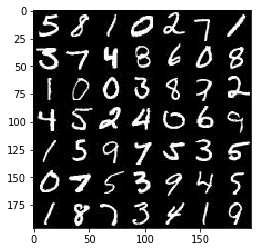

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

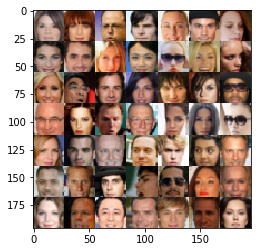

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return inputs_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.1
        keep_prob = 0.9
        
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', activation=None,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x1 = tf.nn.dropout(x1, keep_prob)
        x1 = tf.maximum(alpha*x1,x1)

        x2 = tf.layers.conv2d(x1, 128, 3, strides=1, padding='same',activation=None,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.nn.dropout(x2, keep_prob)
        x2 = tf.maximum(alpha*x2,x2)


        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same',activation=None,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.nn.dropout(x3, keep_prob)
        x3 = tf.maximum(alpha*x3,x3)


        flat = tf.reshape(x3, [-1, 7*7*256])
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        keep_prob = 0.9
        
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 64, 3, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.maximum(x2*alpha, x2)

        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', activation=None,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):

        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                _ = sess.run(disc_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z:batch_z,  lr:learning_rate})
                if steps % 20 == 0:
                    train_loss_d = disc_loss.eval({input_real:batch_images, input_z: batch_z})
                    train_loss_g = gen_loss.eval({input_z:batch_z}) 
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 1.3830
Epoch 1/2... Discriminator Loss: 1.5132... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 1.6858... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 1.7066... Generator Loss: 1.7389
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.5678


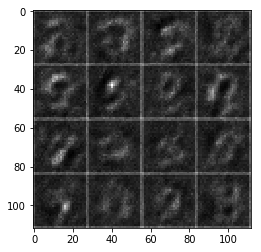

Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 1.3910
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.5738... Generator Loss: 0.4506
Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.5165


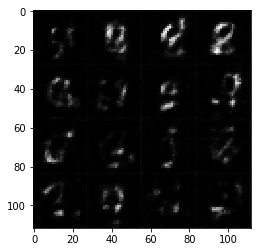

Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 1.0994
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.2267
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 1.7547


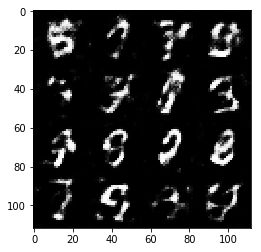

Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 1.9461
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 2.2627


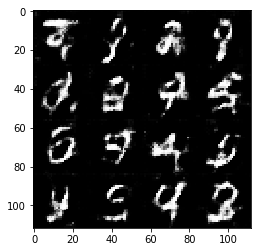

Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 1.1516
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.2447
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 1.4886
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.6991


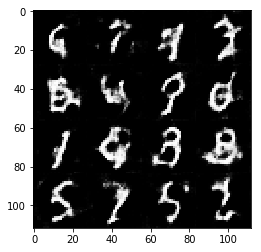

Epoch 1/2... Discriminator Loss: 1.6624... Generator Loss: 0.3824
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.5407
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 1.3748
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 1.5677
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 1.9012


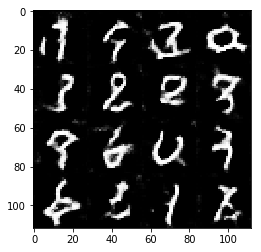

Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 1.3066


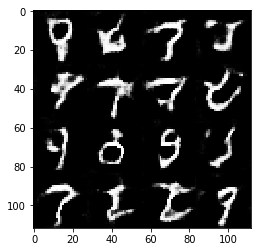

Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.9326
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.9281


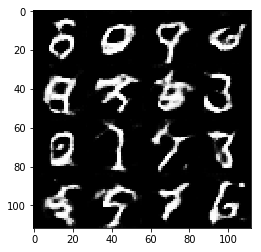

Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.7149
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.0409
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 1.4592


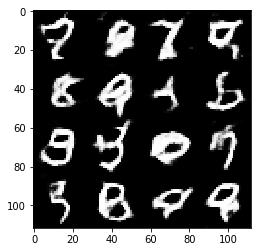

Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 1.1630
Epoch 1/2... Discriminator Loss: 1.6178... Generator Loss: 2.1688
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.8117
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.7045


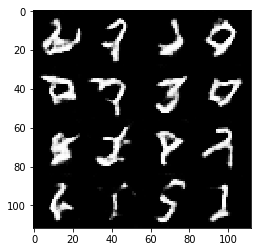

Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 1.5848
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 2.6622
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 1.5826


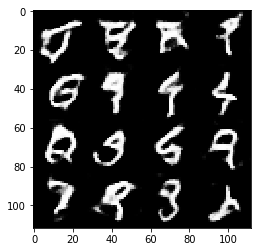

Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 1.5051
Epoch 1/2... Discriminator Loss: 1.5121... Generator Loss: 0.3987
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.6470... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.9146


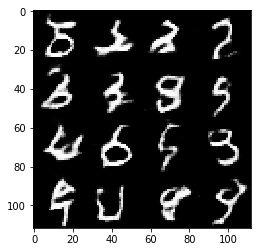

Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.4143
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 0.7189
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 1.5048
Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 1.1034


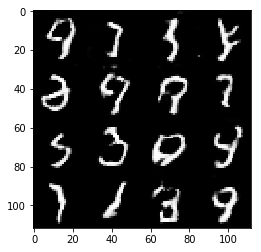

Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 1.3818
Epoch 1/2... Discriminator Loss: 1.4765... Generator Loss: 0.5165
Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.1865


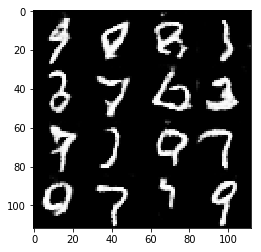

Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.0656
Epoch 1/2... Discriminator Loss: 0.8299... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.6781
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 1.1537
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.5863


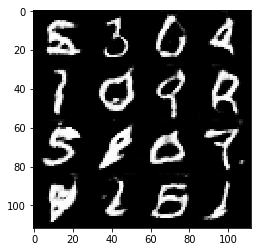

Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 1.7025
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 1.3862
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 1.4145


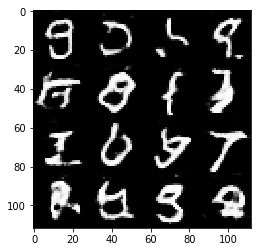

Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 1.8092
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 2.2638
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.9391


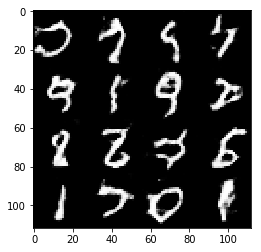

Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.5547
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.3309


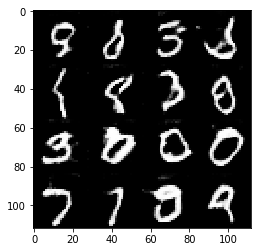

Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 1.8407
Epoch 1/2... Discriminator Loss: 1.6080... Generator Loss: 3.4106
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 1.2875
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.8642
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.3383


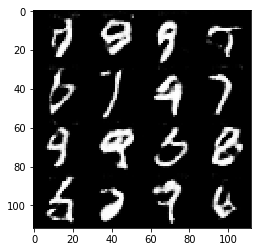

Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.8868
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 1.5187
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.2535


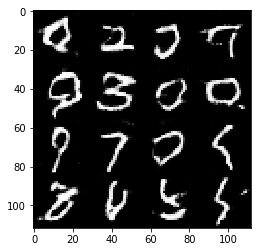

Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.7304
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.7962
Epoch 2/2... Discriminator Loss: 2.0756... Generator Loss: 2.8921
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.5004
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.9977


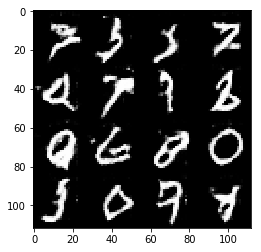

Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.7342
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 2.6411
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.7057


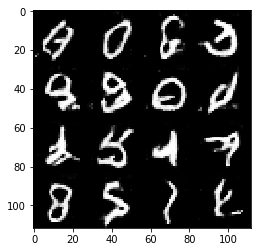

Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 2.4429
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 1.1172
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 1.3436
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.3079


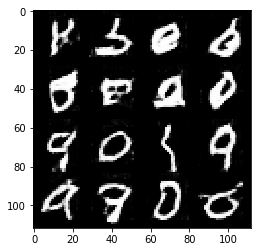

Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.1468
Epoch 2/2... Discriminator Loss: 2.5196... Generator Loss: 4.1374
Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 1.6165
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.6119
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 1.9350


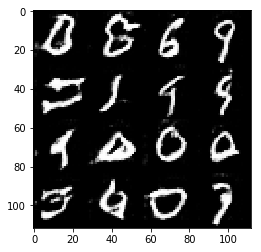

Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 2.2597
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 2.2177
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.9550
Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 1.2645
Epoch 2/2... Discriminator Loss: 0.9584... Generator Loss: 0.9779


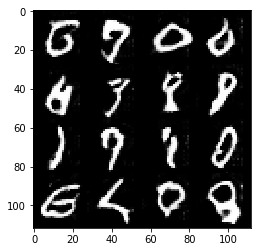

Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 1.6299
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.4825
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 1.1068
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 1.4933
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 1.3486


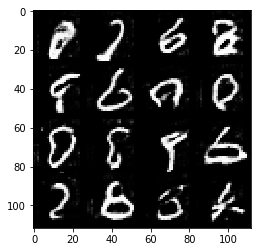

Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 1.5462
Epoch 2/2... Discriminator Loss: 0.8068... Generator Loss: 1.6542
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 1.7059
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 1.8100
Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 1.6094


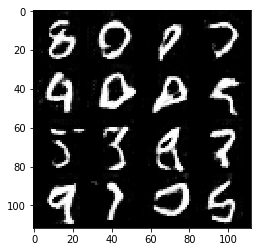

Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 2.0636
Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.5844
Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 1.4491
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 1.8034


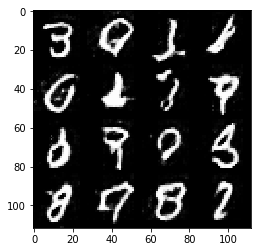

Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.2223
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 1.0650
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 1.2988
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 2.2707... Generator Loss: 2.6864


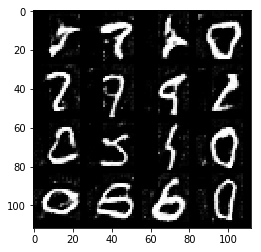

Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.2108
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9827


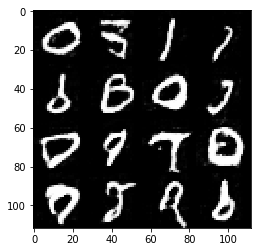

Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 1.2467
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 1.6999
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.1677
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 1.7412


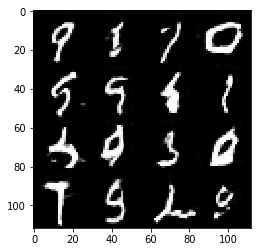

Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 1.4725
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 1.4805
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.8011


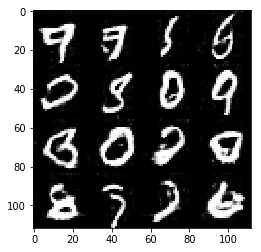

Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 1.0973
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 1.0632
Epoch 2/2... Discriminator Loss: 0.8406... Generator Loss: 1.3927
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 1.1170
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.7080


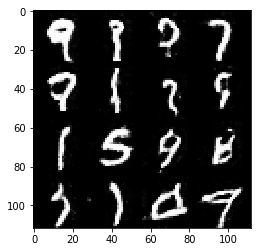

Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.7894
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.8909
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 1.0383


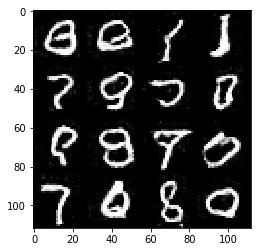

Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.5394
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 1.1752
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.7898
Epoch 2/2... Discriminator Loss: 0.9158... Generator Loss: 2.2969


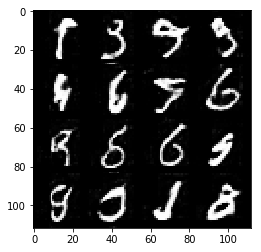

Epoch 2/2... Discriminator Loss: 0.8551... Generator Loss: 1.4689
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.2772
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 1.9991
Epoch 2/2... Discriminator Loss: 0.8551... Generator Loss: 1.3100


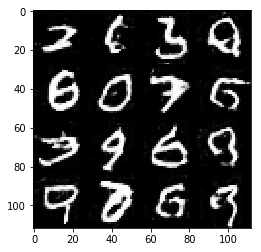

Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 1.1420
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 1.3607
Epoch 2/2... Discriminator Loss: 0.9452... Generator Loss: 1.2821
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 1.0474


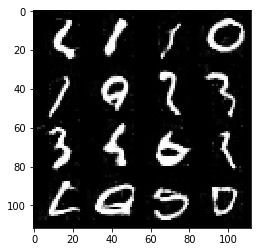

Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.7641
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.3821


In [14]:
tf.reset_default_graph()

batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.8374
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 3.4643
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 4.5736
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 3.4419


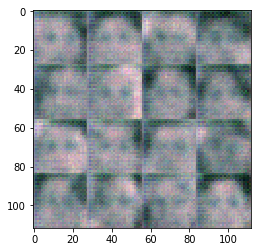

Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 2.2284
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 2.1403
Epoch 1/1... Discriminator Loss: 3.8735... Generator Loss: 0.0841
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 2.5086


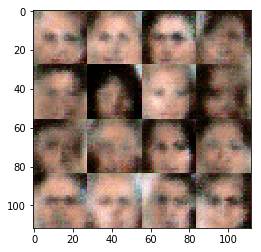

Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 2.2038
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 2.1267
Epoch 1/1... Discriminator Loss: 1.8063... Generator Loss: 2.3732
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 2.1912... Generator Loss: 0.2114


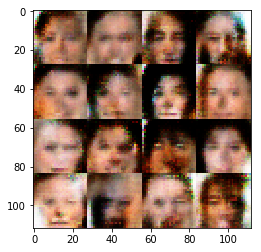

Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.7400... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.8780... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.2266


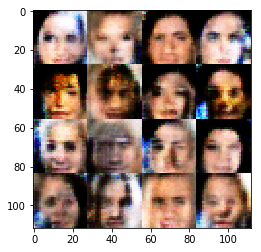

Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.1649


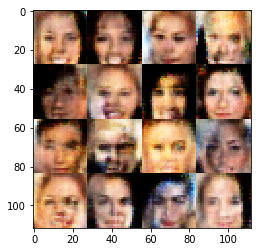

Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.6751... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 1.3551


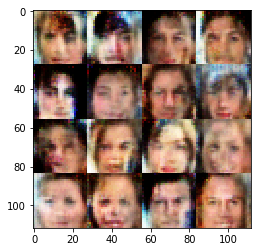

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 1.6593... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.7832
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.6215... Generator Loss: 0.3324


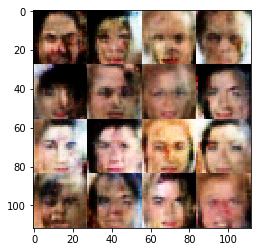

Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.9480
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.2913


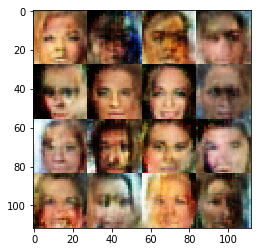

Epoch 1/1... Discriminator Loss: 1.9871... Generator Loss: 0.3166
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 2.0250... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 1.9924
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6648


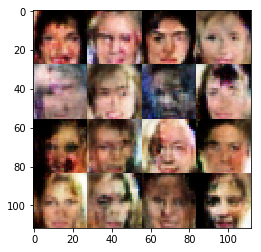

Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.3523
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 1.2703


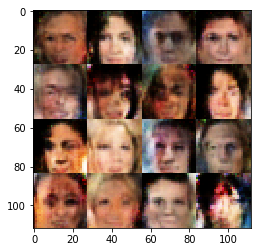

Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.8590


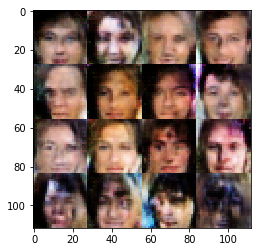

Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 1.8139
Epoch 1/1... Discriminator Loss: 3.3113... Generator Loss: 2.7029
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.8376


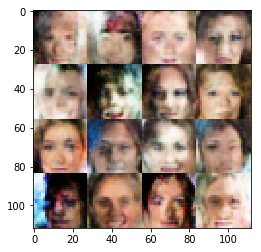

Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.9515... Generator Loss: 0.2759
Epoch 1/1... Discriminator Loss: 2.4829... Generator Loss: 0.1604
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.4533


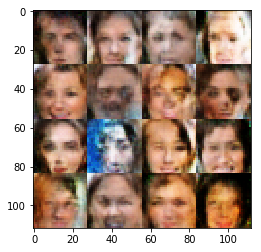

Epoch 1/1... Discriminator Loss: 1.6285... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.5001


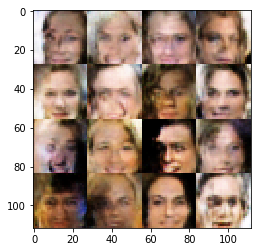

Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 1.2648
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7963


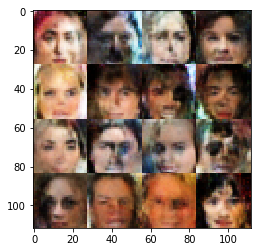

Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.6618... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.8781... Generator Loss: 1.7891


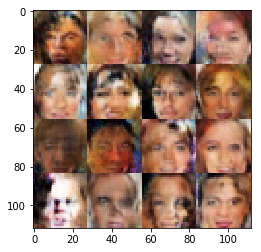

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.4503


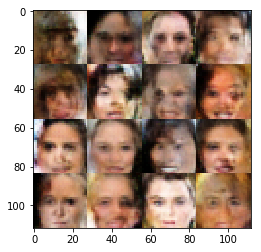

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.6921... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8365


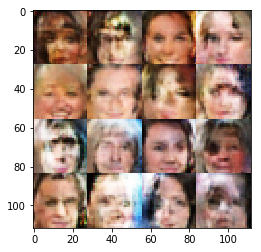

Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 2.0415
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6876


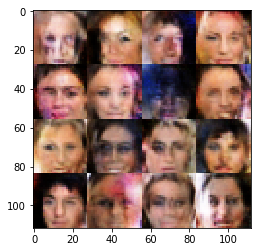

Epoch 1/1... Discriminator Loss: 1.7421... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.3444
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 2.1247... Generator Loss: 0.2540


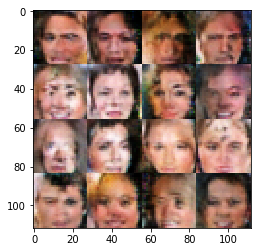

Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.3017
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.8418


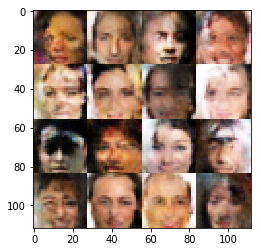

Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.6477... Generator Loss: 0.3191


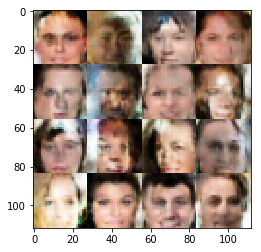

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.9080


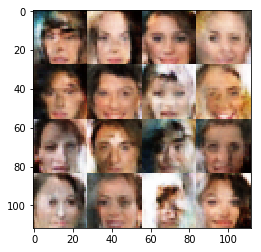

Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 1.4548


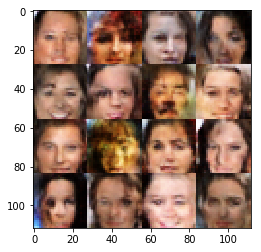

Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 1.1524


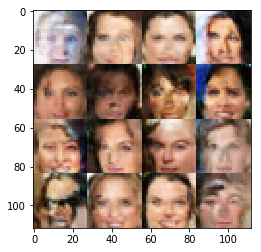

Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.3848
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.5252


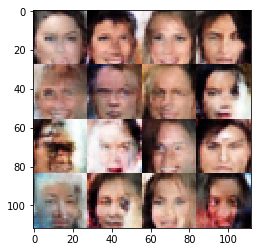

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 2.1364... Generator Loss: 0.2742


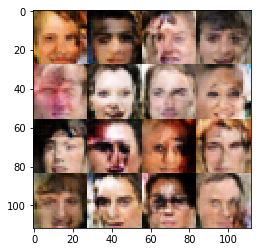

Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.9070


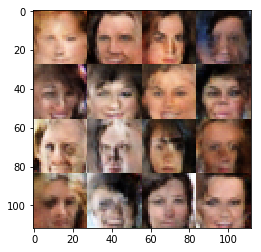

Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 1.5819


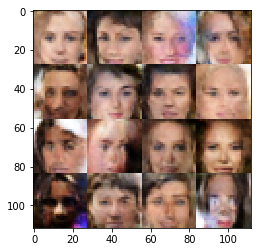

Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5074


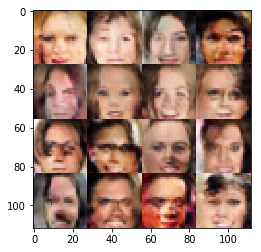

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 1.7700... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4441


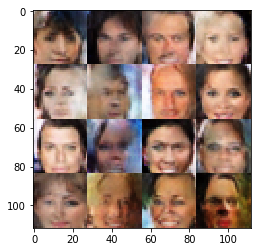

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.9116... Generator Loss: 0.2413
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.4741


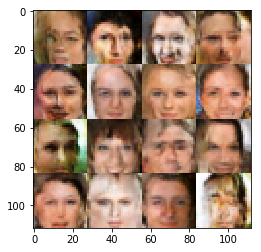

Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.3935


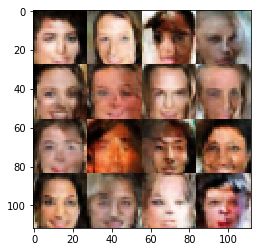

Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.6049


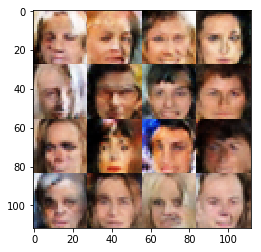

Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.8643... Generator Loss: 0.3428


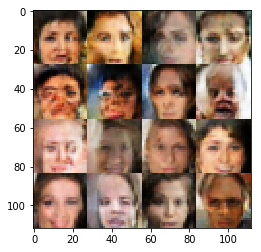

Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7286


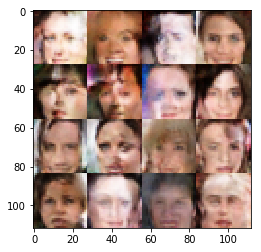

Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9527


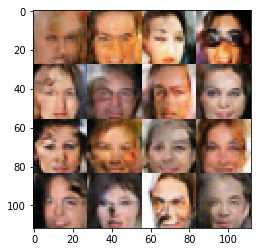

Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7609


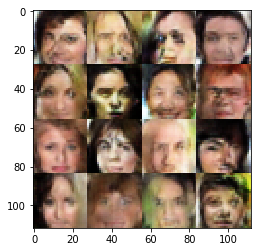

Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8503


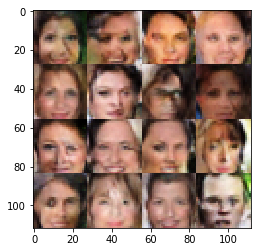

Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6892


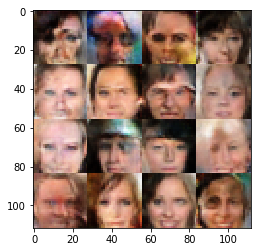

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 1.1256


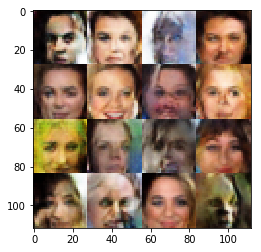

Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.3941


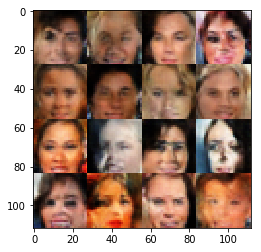

Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 1.7951
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.6806... Generator Loss: 0.3734


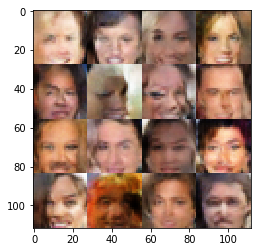

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 1.2836


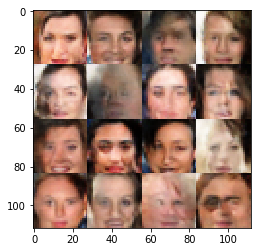

Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 1.4422
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.7954


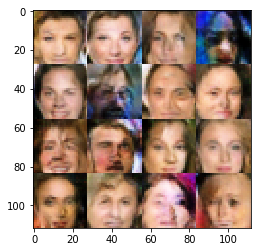

Epoch 1/1... Discriminator Loss: 1.7356... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8140


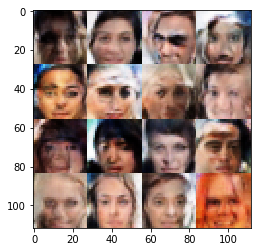

Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.8530


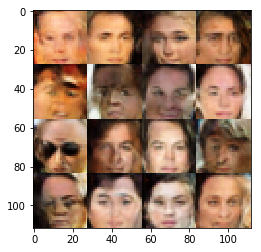

Epoch 1/1... Discriminator Loss: 1.6886... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.6651


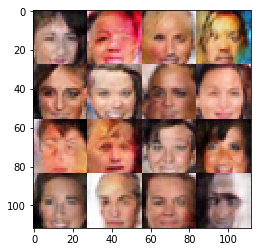

Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.9147


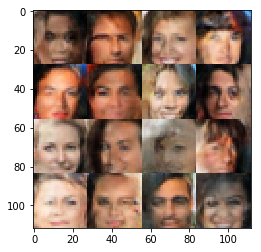

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8272


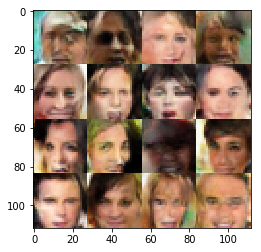

Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.8568


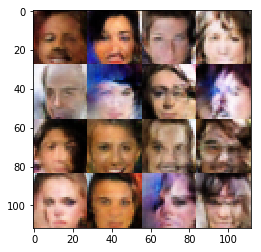

Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.1647


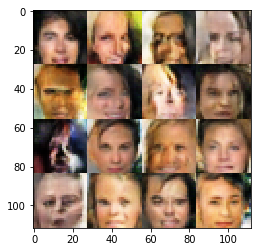

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.7312... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6538


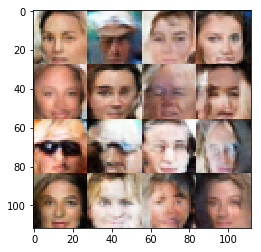

Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.7024... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.5802


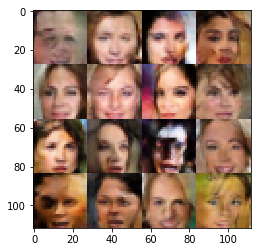

Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9910


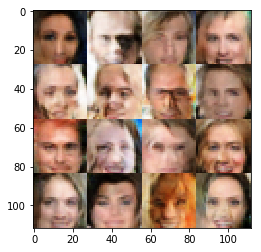

Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 1.3413
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7613


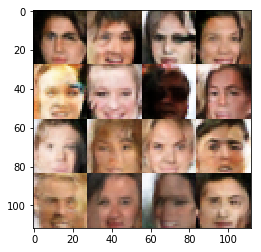

Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.5363


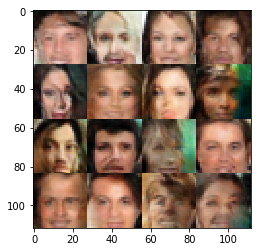

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 1.9241
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7214


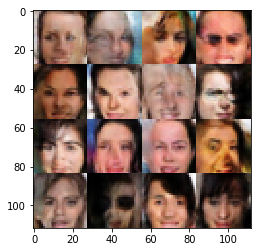

Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.6525... Generator Loss: 1.1289


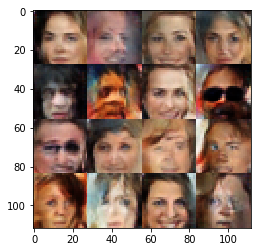

Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 1.0751


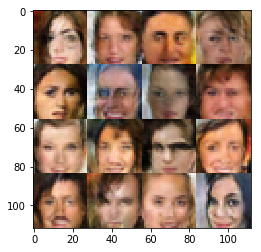

Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 1.2147


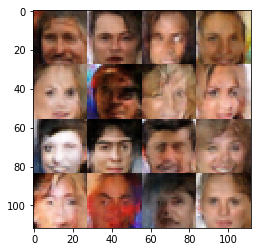

Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.1531


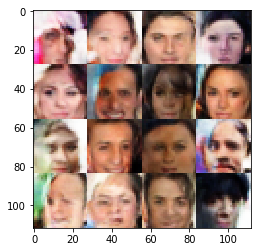

Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6460


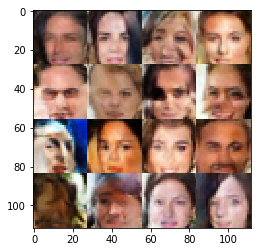

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6726


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.